# Langzeitdaten von Home Assistant auswerten
Ersetzt DB Browser nicht, jedoch kann das mit DB Browser entwickelte SQL-Statement mit jupyter notepad gut visualisiert werden.

Zunächst importieren wir die notwendigen Bibliotheken:

In [1]:
import sqlite3 as db
from dateutil import parser
import matplotlib.pyplot as plt
# Für laufenden Mittelwert
import pandas as pd

Um die python-Autovervollständigung zu nutzen muss folgendes "Magic Command" verwendet werden:

In [2]:
%config Completer.use_jedi = False

Mittels **shift** + **Tab** kann die Hilfe zu einer Funktion aufgerufen werden.
Funktion / Methode muss bereits im Code fertig geschrieben sein, dann kann die Hilfe entsprechend aufgerufen werden.

## Interaktive Plots nutzen
Hierzu wird ein [zusätzliches Paket](https://github.com/matplotlib/ipympl) benötigt. Mittels IPYMPL werden interaktive Widgets ermöglicht. Zum aktivieren wird das magische Kommando `%matplotlib widget` verwendet. Wird anstatt *widget* zu *inline* gewechselt, wird das Plugin wieder deaktiviert.

In [3]:
%matplotlib widget

## Datenbankverbindung herstellen

In [4]:
#connect to database or create if doesn't exist
conn = db.connect('../data/230130_home-assistant_v2.db')

#create cursor
c = conn.cursor()

## Entity-ID herausfinden

In [ ]:
c.execute("""
SELECT A.entity_id, A.attributes
FROM (SELECT DISTINCT entity_id, attributes
FROM states
GROUP BY entity_id) AS A
WHERE A.attributes LIKE "%STUD%";
""")
c.fetchall()

## Beispiel 1: Studio Temperaturen

In [ ]:
#check data in table
c.execute("""
SELECT 'Studio' as sensor, start, mean, min, max 
FROM statistics 
WHERE metadata_id IN (
  SELECT id 
  FROM statistics_meta 
  WHERE statistic_id = 'sensor.28_ff5ad9501603_temperature') 
AND min > -20  AND max < 40
AND start > '2022-01-01'
AND start < '2022-01-20'; --YYYY-MM-DD;""")
data = c.fetchall()
print(data[1])

In [ ]:
dates = []
values = []
for row in data:
    dates.append(parser.parse(row[1]))
    values.append(row[2])


In [ ]:
h = plt.figure(figsize=(12, 5))
plt.plot(dates,values,'-')
h.gca().grid()
#plt.show()
temp_series = pd.Series(values)
plt.plot(dates, temp_series.rolling(5).mean(),'r--')

## Beispiel 2: Temperatur und Luftfeuchte in der Garage
Hier wird eine zweite y-Achse für die Luftfeuchtigkeit angelegt. 

In [ ]:
#check data in table
c.execute("""
SELECT A.start as Time, A.mean as Temperature, HUMID.mean as Humidity 
FROM
  (SELECT "GarageTemp" as sensor, start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_temperature") 
   AND min > -20 
   AND max < 40) AS A,
  (SELECT start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_humidity_htm1735") 
   AND min > 0 
   AND max < 100) AS HUMID
WHERE
  A.start = HUMID.start
  AND A.start > '2022-01-01'
  AND A.start < '2022-01-20'; --YYYY-MM-DD
""")
data = c.fetchall()
print(data[1])

In [ ]:
dates = []
temp = []
humid = []
for row in data:
    dates.append(parser.parse(row[0]))
    temp.append(row[1])
    humid.append(row[2])

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(9)
ax1.grid()
ax1.set_xlabel('Datum / Zeit')
ax1.set_ylabel('Temperatur in °C')
ax1.plot(dates,temp,'-')
#plt.plot_date(dates,humid,'r-')

ax2 = ax1.twinx()
ax2.set_ylabel('Luftfeuchte in %')
ax2.set_ylim(0, 100)
ax2.plot(dates,humid,'r-')

fig.show()
fig.savefig("test.pdf")

## Beispiel 3: Pandas nutzen
Ein schönes getting Started ist auf der [Pandas Webseite](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html) zu finden

In [5]:
data = pd.read_sql_query("""
SELECT A.start as Time, A.mean as Temperature, HUMID.mean as Humidity 
FROM
  (SELECT "GarageTemp" as sensor, start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_temperature") 
   AND min > -20 
   AND max < 40) AS A,
  (SELECT start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_humidity_htm1735") 
   AND min > 0 
   AND max < 100) AS HUMID
WHERE
  A.start = HUMID.start;
""", conn, parse_dates=["Time"])

# Zeiten selektieren
#data[data["Time"] > "2022-01-18"]

# Index nicht mehr numerisch, sondern das Datetime-Feld nutzen
data = data.set_index('Time')

# Anzeigen
data

,Temperature,Humidity
Time,,
2021-12-09 08:00:00,6.556090,79.500000
2021-12-09 09:00:00,6.563778,79.122437
2021-12-09 10:00:00,6.488567,78.707663
2021-12-09 14:00:00,6.321682,79.092574
2021-12-09 19:00:00,7.230700,83.183896
...,...,...
2023-01-29 14:00:00,4.735807,76.990374
2023-01-29 18:00:00,4.620082,77.483561
2023-01-29 20:00:00,4.489024,77.500000


### Temperaturverlauf mehrerer Monate

findfont: Font family ['LiberationSans'] not found. Falling back to DejaVu Sans.


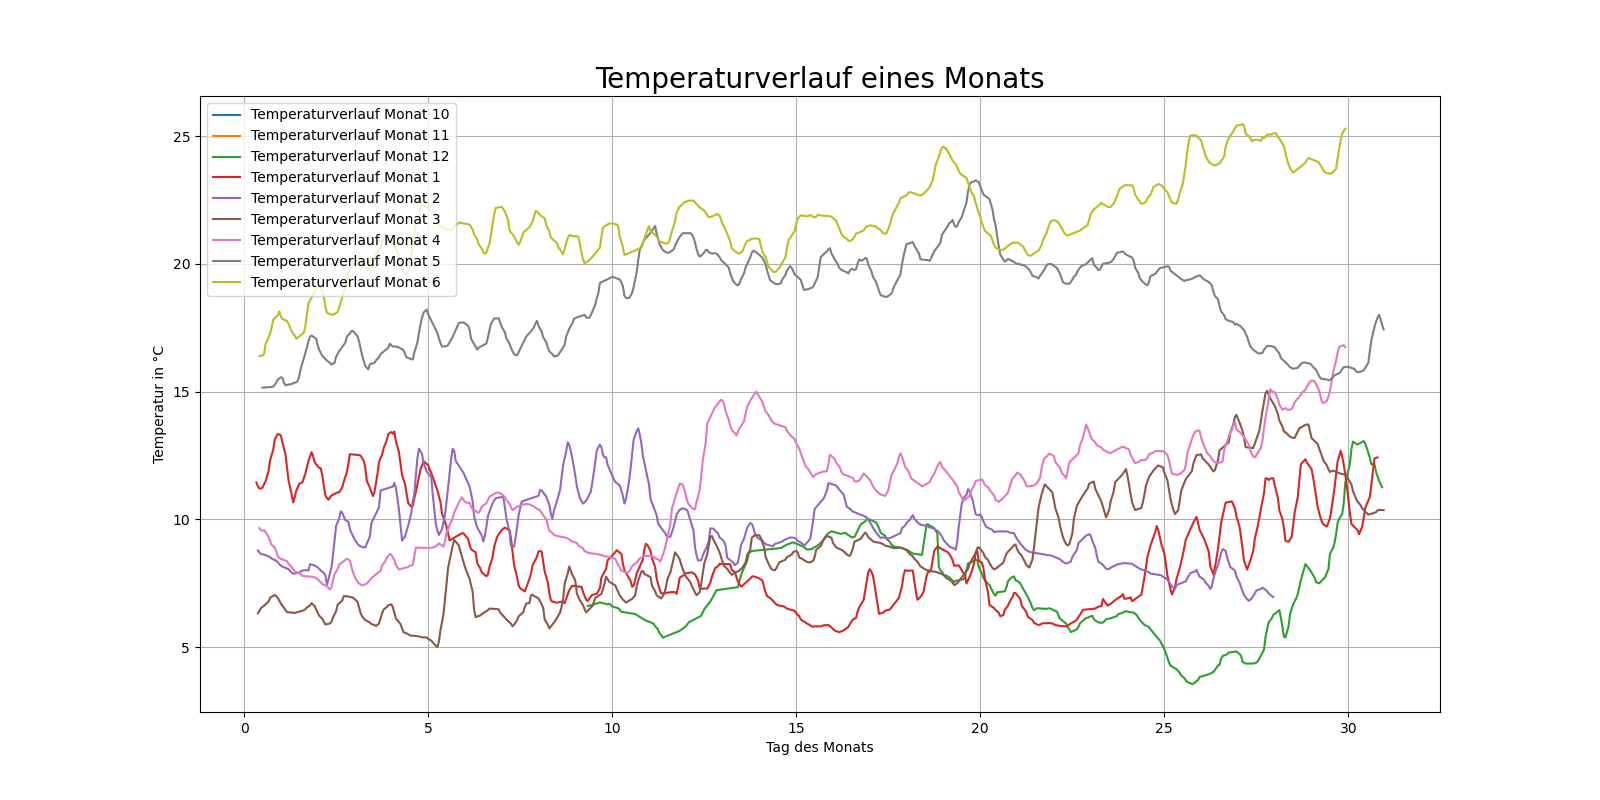

In [6]:
# Ein Jahr / eine Jahresscheibe aus den Daten holen
plotdata = data["2021-10-01":"2022-06-30"]
h = plt.figure(figsize=(16, 8))
ax = h.gca()
ax.grid()
ax.set_title("Temperaturverlauf eines Monats",font='LiberationSans', size=20)
ax.set_xlabel("Tag des Monats")
ax.set_ylabel("Temperatur in °C")
for i in [10,11,12,1,2,3,4,5,6]:
    test = plotdata[plotdata.index.month == i]
    plt.plot(test.index.day - 1 + (test.index.hour)/24.0,test.Temperature.rolling(7).mean(),'-', label="Temperaturverlauf Monat %i" % (i))
plt.legend()

### Einfacher Temperaturverlauf (Zeitraum)

In [ ]:
plotdata = data["2022-07-01":"2022-07-07"]

h = plt.figure(figsize=(16, 8))
h.gca().grid()

plt.plot(plotdata.index,plotdata.Temperature,'-', label="Temperaturverlauf")
plt.legend()

### Temperaturverlauf Lebenszeit

In [ ]:
plotdata = data

h = plt.figure(figsize=(16, 8))
h.gca().grid()

plt.plot(plotdata.index,plotdata.Temperature.rolling(48).mean(),'-', label="Temperaturverlauf Window 48")
plt.legend()

ax1 = h.gca()
ax1.set_ylabel('Temperatur in °C')
ax2 = ax1.twinx()
ax2.set_ylabel('Luftfeuchte in %')
ax2.set_ylim(30, 100)
ax1.set_ylim(-5, 30) #grid gleich halten
ax2.plot(plotdata.index,plotdata.Humidity.rolling(48).mean(),'r-', label="Feuchteverlauf Window 48")
ax2.legend()

### Typ. Tagestemperaturverlauf im Juni

In [ ]:
plotdata = data["2022-06-01":"2022-06-30"]
plotdata = plotdata.reset_index()
fig, axs = plt.subplots(figsize=(12, 4))
plotdata.groupby(plotdata["Time"].dt.hour)["Temperature"].mean().plot(kind='bar', rot=0, ax=axs)
axs.grid()
axs.set_ylim(15,30)


### Boxplot gruppiert für Monat

In [48]:
plotdata = data #["2022-06-01":"2022-07-30"]
#plotdata = plotdata.reset_index()
plotdata['TimeGroup'] = plotdata.index.to_period('M')
plotdata.groupby('TimeGroup').median()

,Temperature,Humidity
TimeGroup,,
2021-12,7.011915,79.175731
2022-01,8.000304,67.297088
2022-02,9.199171,68.032026
2022-03,8.448578,56.834171
2022-04,11.539924,64.370261
2022-05,18.765278,52.644515
2022-06,21.623743,55.100617
2022-07,22.505036,52.120269
2022-08,22.263279,57.653053


<AxesSubplot:title={'center':'Temperature'}, xlabel='TimeGroup'>

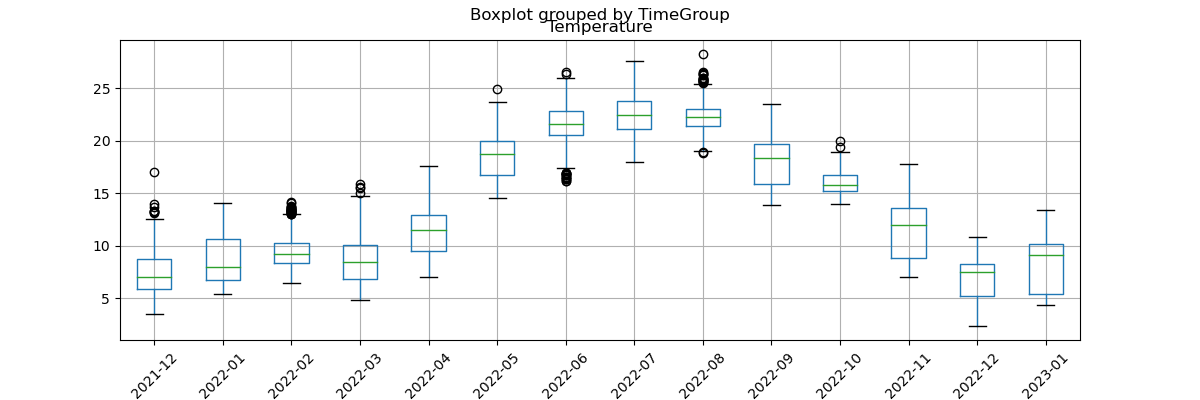

In [53]:
fig, axs = plt.subplots(figsize=(12, 4))
plotdata.boxplot(by='TimeGroup',column='Temperature',rot=45,ax=axs)

#plotdata.boxplot(by=['Time'],ax=axs)
#(plotdata[['Time','Temperature']]).boxplot(by='month', column='Time')
#groupby(plotdata["Time"].dt.month).plot(kind='box',ax=axs)
#plotdata.boxplot(ax=axs)

In [55]:
data = pd.read_sql_query("""
SELECT start AS Time, mean AS Temperature
FROM statistics 
WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.28_ff5ad9501603_temperature") 
AND min > -20 
AND max < 40;
""", conn, parse_dates=["Time"])

# Zeiten selektieren
#data[data["Time"] > "2022-01-18"]

# Index nicht mehr numerisch, sondern das Datetime-Feld nutzen
data = data.set_index('Time')

data

,Temperature
Time,
2021-10-04 10:00:00,24.000000
2021-10-04 11:00:00,24.000000
2021-10-04 12:00:00,24.044342
2021-10-04 13:00:00,24.100000
2021-10-04 14:00:00,24.033312
...,...
2023-01-29 18:00:00,19.800793
2023-01-29 19:00:00,19.805816
2023-01-29 20:00:00,19.800820


Text(0.5, 1.0, 'test')

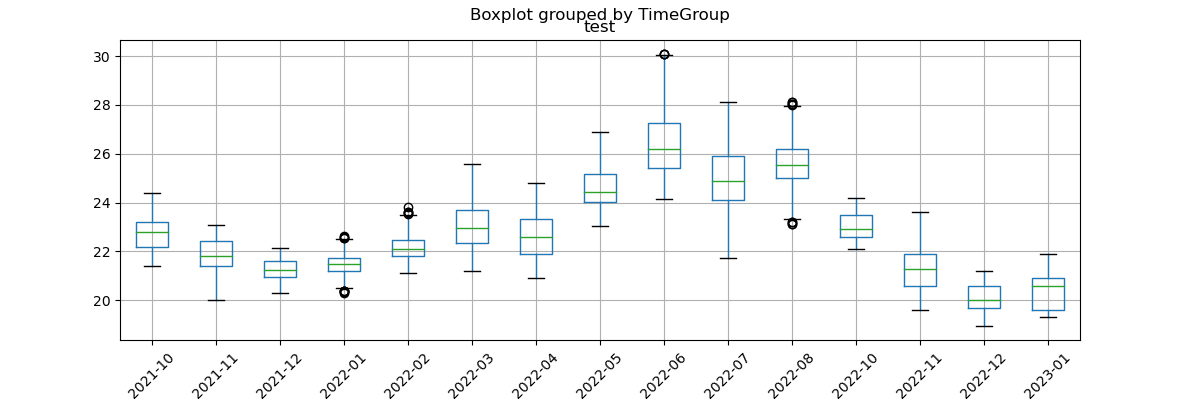

In [63]:
plotdata = data
plotdata['TimeGroup'] = plotdata.index.to_period('M')
fig, axs = plt.subplots(figsize=(12, 4))
plotdata.boxplot(by='TimeGroup',column='Temperature',rot=45,ax=axs)

axs.set_title('test')

In [68]:
type(fig)

matplotlib.figure.Figure

## Datenbankverbindung beenden

c.close()
conn.close()